# 1. IMPORT LIBRARIES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re, string

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from textblob import TextBlob
from textblob import Word

# for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# for word embedding
import gensim
from gensim.models import Word2Vec

# 2. IMPORT DATA

<AxesSubplot:ylabel='label'>

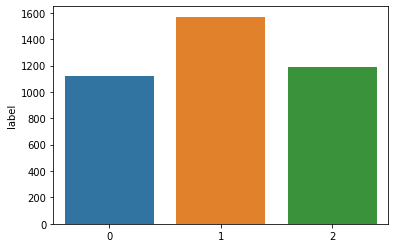

In [2]:
negative_tweets = pd.read_csv("data/processedNegative.csv")
neutral_tweets = pd.read_csv("data/processedNeutral.csv")
positive_tweets = pd.read_csv("data/processedPositive.csv")

negative_df = pd.DataFrame({'tweets':negative_tweets.columns, 'label':0})
neutral_df = pd.DataFrame({'tweets':neutral_tweets.columns, 'label':1})
positive_df = pd.DataFrame({'tweets':positive_tweets.columns, 'label':2})

data = pd.concat([negative_df, neutral_df, positive_df])
data = data.sample(frac=1).reset_index(drop=True)

x = data['label'].value_counts()
sns.barplot(x=x.index, y=x)

# 3. PREPROCESS

In [3]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

data['preprocessed'] = data['tweets'].apply(lambda x: preprocess(x))
data['no_stopwords'] = data['preprocessed'].apply(lambda x: stopword(x))
data['tokenized'] = data['no_stopwords'].apply(tokenizer.tokenize)
data[['preprocessed', 'no_stopwords', 'tokenized', 'label']].head()

,preprocessed,no_stopwords,tokenized,label
0,seem i want to drop this account to wuhyungwon...,seem want drop account wuhyungwon unhappy,"[seem, want, drop, account, wuhyungwon, unhappy]",0
1,nice gif happy,nice gif happy,"[nice, gif, happy]",2
2,that would be a great trick happy,would great trick happy,"[would, great, trick, happy]",2
3,uk parliament votes by to in favour of early n...,uk parliament votes favour early national,"[uk, parliament, votes, favour, early, national]",1
4,this is by far my worst day of since january t...,far worst day since january th unhappy crying ...,"[far, worst, day, since, january, th, unhappy,...",0


# 4. Misspelling correction (choose one)

### 4.1. choose this if u want to make correction (take time)

In [4]:
def spell_correction(list_tokens):
    ret_list = []
    for token in list_tokens:
        w = Word(token)
        if (w.spellcheck()[0][1] != 1.0):
            ret_list.append(w.correct())
        else:
            ret_list.append(w)
    return ret_list

data['corrected'] = data['tokenized'].apply(spell_correction)
data[['tokenized', 'corrected']].head()

,tokenized,corrected
0,"[seem, want, drop, account, wuhyungwon, unhappy]","[seem, want, drop, account, wuhyungwon, unhappy]"
1,"[nice, gif, happy]","[nice, if, happy]"
2,"[would, great, trick, happy]","[would, great, trick, happy]"
3,"[uk, parliament, votes, favour, early, national]","[up, parliament, votes, favour, early, national]"
4,"[far, worst, day, since, january, th, unhappy,...","[far, worst, day, since, january, th, unhappy,..."


### 4.2. or choose this if u dont want to make correction

In [ ]:
data['corrected'] = data['tokenized']
data[['tokenized', 'corrected']].head()

# 5. Stemmed/lemmed/stemmed+corr/lemmed+corr

In [5]:
stemmer = nltk.stem.PorterStemmer()
lememr = nltk.stem.WordNetLemmatizer()

def stem_words(tokenized_string):
    return (" ".join(stemmer.stem(token) for token in tokenized_string))

def lem_words(tokenized_string):
    return (" ".join(lememr.lemmatize(token) for token in tokenized_string))

data['stemmed'] = data['tokenized'].apply(lambda x: stem_words(x))
data['lemmed'] = data['tokenized'].apply(lambda x: lem_words(x))
data['stemmed+corrected'] = data['corrected'].apply(lambda x: stem_words(x))
data['lemmed+corrected'] = data['corrected'].apply(lambda x: lem_words(x))
data[['tokenized', 'stemmed', 'lemmed', 'stemmed+corrected', 'lemmed+corrected']].head()

,tokenized,stemmed,lemmed,stemmed+corrected,lemmed+corrected
0,"[seem, want, drop, account, wuhyungwon, unhappy]",seem want drop account wuhyungwon unhappi,seem want drop account wuhyungwon unhappy,seem want drop account wuhyungwon unhappi,seem want drop account wuhyungwon unhappy
1,"[nice, gif, happy]",nice gif happi,nice gif happy,nice if happi,nice if happy
2,"[would, great, trick, happy]",would great trick happi,would great trick happy,would great trick happi,would great trick happy
3,"[uk, parliament, votes, favour, early, national]",uk parliament vote favour earli nation,uk parliament vote favour early national,up parliament vote favour earli nation,up parliament vote favour early national
4,"[far, worst, day, since, january, th, unhappy,...",far worst day sinc januari th unhappi cri cri,far worst day since january th unhappy cry cry,far worst day sinc januari th unhappi cri cri,far worst day since january th unhappy cry cry


# 6. Find similar tweets

In [6]:
def print_most_similar(index_list, dataframe):
    for i in range(10):
        tmp_dict = index_list[i]
        for key in tmp_dict.keys():
            tmp_key = key
        print("{0}: {1}\n{2}: {3}\n cos:{4}\n\n".format(tmp_key, 
                                                        dataframe[tmp_key],
                                                        tmp_dict[tmp_key][0],
                                                        dataframe[tmp_dict[tmp_key][0]],
                                                        tmp_dict[tmp_key][1]))

def find_similar(dataframe):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(dataframe).toarray()
    cos_sim = cosine_similarity(X)
    similarity_df = pd.DataFrame(cos_sim)

    similarity_list = []

    for i in range(similarity_df.shape[0]):
        x = similarity_df[i].nlargest(n=2)
        if x.iloc[1] >= 0.95 and i != x.index[1]:
            similarity_list.append({i:[x.index[1], x.iloc[1]]})

    print_most_similar(similarity_list, dataframe)

## 6.1. Similar default

In [7]:
find_similar(data['tweets'])

2: That would be a great trick happy
832: That would be a great trick happy.6
 cos:1.0000000000000002


10: Good evening happy.1
100: Good evening happy
 cos:1.0000000000000002


11: US gives a scare
1527: US gives a scare.1
 cos:1.0000000000000002


13: thanks b happy
552: .Thanks happy
 cos:0.9999999999999998


15: YG should have sent them to MCD. I want to see them holding the trophy unhappy  anyways .9
909: YG should have sent them to MCD. I want to see them holding the trophy unhappy  anyways 
 cos:1.0


18: Definitely my arms unhappy  .4
864: Definitely my arms unhappy  .5
 cos:1.0


21: This never happened with our happy.1
3464: This never happened with our happy
 cos:1.0000000000000002


36: Thanks for the recent follow Happy to connect happy  have a great Thursday. Get it.2
2174: Thanks for the recent follow Happy to connect happy  have a great Thursday. Get it.1
 cos:1.0


46: Stats for the week have arrived. 1 new follower and NO unfollowers happy  via.2
785: Stats for the w

## 6.2. Similar stemmed

In [8]:
find_similar(data['stemmed'])

2: would great trick happi
524: would great trick happi
 cos:1.0


5: wait u unhappi
56: wait unhappi
 cos:0.9999999999999998


10: good even happi
100: good even happi
 cos:1.0000000000000002


11: us give scare
1527: us give scare
 cos:1.0000000000000002


13: thank b happi
377: thank happi
 cos:0.9999999999999998


15: yg sent mcd want see hold trophi unhappi anyway
909: yg sent mcd want see hold trophi unhappi anyway
 cos:1.0000000000000002


16: miss unhappi
196: miss unhappi
 cos:0.9999999999999998


18: definit arm unhappi
144: definit arm unhappi
 cos:1.0000000000000002


21: never happen happi
3464: never happen happi
 cos:1.0000000000000002


36: thank recent follow happi connect happi great thursday get
1828: thank recent follow happi connect happi great thursday get
 cos:1.0




## 6.3. Similar lemmed

In [9]:
find_similar(data['lemmed'])

2: would great trick happy
524: would great trick happy
 cos:1.0


5: waited u unhappy
56: waited unhappy
 cos:0.9999999999999998


10: good evening happy
100: good evening happy
 cos:1.0000000000000002


11: u give scare
1527: u give scare
 cos:0.9999999999999998


13: thanks b happy
552: thanks happy
 cos:0.9999999999999998


15: yg sent mcd want see holding trophy unhappy anyways
909: yg sent mcd want see holding trophy unhappy anyways
 cos:1.0000000000000002


16: miss unhappy
196: miss unhappy
 cos:0.9999999999999998


18: definitely arm unhappy
144: definitely arm unhappy
 cos:1.0000000000000002


21: never happened happy
3464: never happened happy
 cos:1.0000000000000002


36: thanks recent follow happy connect happy great thursday get
1828: thanks recent follow happy connect happy great thursday get
 cos:1.0




## 6.4. Similar stemmed+corrected

In [10]:
find_similar(data['stemmed+corrected'])

2: would great trick happi
524: would great trick happi
 cos:1.0


5: wait u unhappi
56: wait unhappi
 cos:0.9999999999999998


10: good even happi
100: good even happi
 cos:1.0000000000000002


11: us give scare
1527: us give scare
 cos:1.0000000000000002


13: thank b happi
377: thank happi
 cos:0.9999999999999998


15: g sent mud want see hold trophi unhappi anyway
909: g sent mud want see hold trophi unhappi anyway
 cos:0.9999999999999998


16: miss unhappi
196: miss unhappi
 cos:0.9999999999999998


18: definit arm unhappi
144: definit arm unhappi
 cos:1.0000000000000002


21: never happen happi
3464: never happen happi
 cos:1.0000000000000002


36: thank recent follow happi connect happi great thursday get
1828: thank recent follow happi connect happi great thursday get
 cos:1.0




## 6.5. Similar lemmed+corrected

In [11]:
find_similar(data['lemmed+corrected'])

2: would great trick happy
524: would great trick happy
 cos:1.0


5: waited u unhappy
56: waited unhappy
 cos:0.9999999999999998


10: good evening happy
100: good evening happy
 cos:1.0000000000000002


11: u give scare
1527: u give scare
 cos:0.9999999999999998


13: thanks b happy
552: thanks happy
 cos:0.9999999999999998


15: g sent mud want see holding trophy unhappy anyways
909: g sent mud want see holding trophy unhappy anyways
 cos:0.9999999999999998


16: miss unhappy
196: miss unhappy
 cos:0.9999999999999998


18: definitely arm unhappy
144: definitely arm unhappy
 cos:1.0000000000000002


21: never happened happy
3464: never happened happy
 cos:1.0000000000000002


36: thanks recent follow happy connect happy great thursday get
1828: thanks recent follow happy connect happy great thursday get
 cos:1.0




# 7. Model training
## 7.1 Split data

In [24]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(data["lemmed+corrected"],data["label"],test_size=0.2)

#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

## 7.2 Create TFIDF and W2Vec

In [25]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self

    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                         or [np.zeros(self.dim)], axis=0)
                         for words in X])

data['clean_data_tokens'] = [nltk.word_tokenize(i) for i in data["lemmed+corrected"]]
model = Word2Vec(data['clean_data_tokens'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

## 7.3 Training TFIDF model

In [26]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,y_predict))
print(accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       205
           1       0.85      0.96      0.90       322
           2       0.90      0.85      0.87       248

    accuracy                           0.88       775
   macro avg       0.89      0.87      0.88       775
weighted avg       0.88      0.88      0.88       775

0.88


## 7.3 Training W2Vec model

In [27]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,y_predict))
print(accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       205
           1       0.66      0.90      0.76       322
           2       0.93      0.58      0.71       248

    accuracy                           0.73       775
   macro avg       0.78      0.71      0.72       775
weighted avg       0.77      0.73      0.73       775

0.7316129032258064
